-------------------

# SEIS 763 - Group 2
## Student GPA Prediction Analysis (HSLS:09)
### Authors: `Abanoub Lamie`, `Elizabeth Izaguirre`, `Emma Depape​`, `Tony Challeen`


**Objective:** Predict student Grade Point Average (`X5GPAALL`) categories using demographic and academic features from the High School Longitudinal Study of 2009.

**Methodology:**
1.  **Preprocessing:** Imputation of missing values and standardization of numerical features.
2.  **Balancing:** Application of SMOTE to handle class imbalance in GPA categories.
3.  **Feature Engineering:** Feature selection via Backward Elimination and dimensionality reduction (PCA, LDA, Kernel PCA).
4.  **Modeling:** Benchmarking classifiers (Logistic Regression, SGD, XGBoost, Random Forest, SVC, AdaBoost, Naive Bayes).
5.  **Ensemble & Evaluation:** Creating a Voting Classifier and comparing performance metrics.

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings

warnings.filterwarnings('ignore')

In [2]:
# globals
seed = 42

## Data Loading

In [3]:
# instantiate resources json
with open("./utils/student_info_updated.json", "r") as file:
    resources = json.load(file)

# instantiate list of categorical features
categorical = resources['categorical']

# instantiate list of numerical features
numerical = resources['numerical']

# instantiate list of boolean features
booleans = resources['boolean']

# instantiate list of full feature set
features = categorical + booleans + numerical

In [4]:
df = pd.read_csv('./data/our_features_cleaned.csv')
display(df.head())
print(f"Shape of dataset: {df.shape}\n")
print(f"Unique target values: {df['X5GPAALL'].unique()}")

,STU_ID,X1TXMTSCOR,X1PAREDU,X1SES,X1MTHINT,X1SCIINT,X2TXMTSCOR,X2PAREDU,X2BEHAVEIN,X2MTHINT_R,...,A1MSPRGMS,A1HRTEACHERS,A1HRSTUDENT,A1TCHRABSENT,A1PRNTINV,A1UNPREP,A1HEALTH,A1RESOURCES,C1PLANPARENT,C1SIGNOFF
0,10001.0,59.3710,5.0,1.5644,0.12,-0.23,68.6447,6.0,-2.17,-0.21,...,1.0,5.0,3.0,1.0,2.0,1.0,1.0,2.0,-7.0,-7.0
1,10002.0,47.6821,3.0,-0.3699,-9.00,-9.00,54.0863,4.0,0.61,-0.60,...,0.0,7.0,9.0,2.0,3.0,3.0,3.0,2.0,-9.0,-9.0
2,10003.0,64.2431,7.0,1.2741,0.86,0.93,55.6336,7.0,0.52,-1.39,...,1.0,15.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0
3,10006.0,58.1268,3.0,1.0639,2.08,-7.00,53.9958,5.0,0.89,-7.00,...,0.0,3.0,6.0,-9.0,4.0,4.0,2.0,2.0,1.0,1.0
4,10007.0,49.4960,2.0,-0.4300,2.08,0.16,47.6403,2.0,0.39,-0.47,...,1.0,8.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Shape of dataset: (12588, 54)

Unique target values: [3 1 0 2]


In [5]:
df = df.drop(columns=["STU_ID"])
df.X5GPAALL.value_counts()

X5GPAALL
1    4107
2    3164
3    2899
0    2418
Name: count, dtype: int64

In [6]:
df = df.replace([-1,-2,-3,-4,-5,-6,-7,-8,-9],np.nan)

In [7]:
print(f"Missing values per column: \n{df.isnull().sum()}")

Missing values per column: 
X1TXMTSCOR        971
X1PAREDU         2829
X1SES             971
X1MTHINT         2242
X1SCIINT         3203
X2TXMTSCOR        837
X2PAREDU          724
X2BEHAVEIN       1146
X2MTHINT_R       2612
X2SCIINT         3145
X3TGPAHIMTH       705
X3TGPAHISCI       674
X3TGPAACAD        599
X3TGPASTEM        601
X4X2SES           724
X5GPAALL            0
S1GOODGRADES     1117
S1HRMHOMEWK      2051
S1HRSHOMEWK      2786
S1HROTHHOMWK     1264
S1HRACTIVITY     1290
S1HRTV           1262
S1HRVIDEO        1545
S1HRONLINE       1358
S2LATESCH         921
S2ABSENT          965
S2WOHWDN          951
S2WOPAPER         921
S2WOBOOKS         944
S2SKIPCLASS       943
S2INSCHSUSP       947
S2OUTSCHSUSP    12509
S2DISCIPLINE    12509
S2EXPELLED      12510
S2ARRESTED      12509
S2JUVHOME       12509
A1SCHCONTROL      684
A1MTHSCIFAIR     1729
A1MSSUMMER       1729
A1MSAFTERSCH     1729
A1MSMENTOR       1729
A1MSSPEAKER      1729
A1MSFLDTRIP      1729
A1MSPRGMS        1729
A1HR

In [8]:
# "S2OUTSCHSUSP", "S2DISCIPLINE", "S2EXPELLED", "S2ARRESTED", "S2JUVHOME" will be removed due to the large number of missing values
df = df.drop(columns=["S2OUTSCHSUSP", "S2DISCIPLINE", "S2EXPELLED", "S2ARRESTED", "S2JUVHOME"])

In [9]:
X = df.drop(columns=["X5GPAALL"])
y = df.X5GPAALL

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = seed, stratify=y
)

### Preprocessing: Imputation & Scaling
To prepare the raw survey data for machine learning, we apply the following transformations:
* **Imputation:** Missing numerical values are filled with the **mean**, while categorical missing values are filled with the **most frequent** category.
* **Scaling:** We apply `StandardScaler` (Z-score normalization) to ensure features contribute equally to distance-based algorithms like SVM and PCA.

In [11]:
from sklearn.impute import SimpleImputer

cat_cols = categorical + booleans
num_cols = numerical

num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

#fit and transform training
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=cat_cols, index=X_train.index)

#transform testing
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
X_test_cat_imp = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns=cat_cols, index=X_test.index)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_num_imp), columns=num_cols, index=X_train.index)
X_test_scale = pd.DataFrame(scaler.transform(X_test_num_imp), columns=num_cols, index=X_test.index)

X_train_final = pd.concat([X_train_scale, X_train_cat_imp], axis=1)
X_test_final = pd.concat([X_test_scale, X_test_cat_imp], axis=1)

### Addressing Class Imbalance (SMOTE)
The target variable `X5GPAALL` has uneven class distribution. To prevent the model from biasing toward the majority class, we use **SMOTE (Synthetic Minority Over-sampling Technique)**.


* **Logic:** SMOTE generates synthetic training examples by interpolating between existing minority instances rather than simply duplicating them.
* **Note:** This is applied *only* to the training set to prevent data leakage.

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=seed)

X_train_final, y_train_final = smote.fit_resample(X_train_final, y_train)

print(f"No. of SMOTE instances: {len(y_train_final)}")
print(f"No. of zero instances: {sum(y_train_final==0)}")
print(f"No. of one instances: {sum(y_train_final==1)}")
print(f"No. of two instances: {sum(y_train_final==2)}")

c:\Users\abano\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\abano\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\abano\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abano\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

No. of SMOTE instances: 12320
No. of zero instances: 3080
No. of one instances: 3080
No. of two instances: 3080


## Baseline Multi-class Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model.fit(X_train_final, y_train_final)

mlr_y_hat1 = mlr_model.predict(X_test_final)

mlr_precision_1 = precision_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Precision:", mlr_precision_1)
mlr_recall_1 = recall_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Recall:", mlr_recall_1)
mlr_f1_1 = f1_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_1)
mlr_accuracy_1 = accuracy_score(y_test, mlr_y_hat1)
print("Accuracy:", mlr_accuracy_1)
print(classification_report(y_test, mlr_y_hat1, zero_division=0))

Precision: 0.41878643154583073
Recall: 0.45051440414167765
F1 Score: 0.42124361845127206
Accuracy: 0.4238957737527804
              precision    recall  f1-score   support

           0       0.43      0.60      0.50       604
           1       0.45      0.27      0.34      1027
           2       0.34      0.28      0.31       791
           3       0.47      0.65      0.54       725

    accuracy                           0.42      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.42      0.41      3147



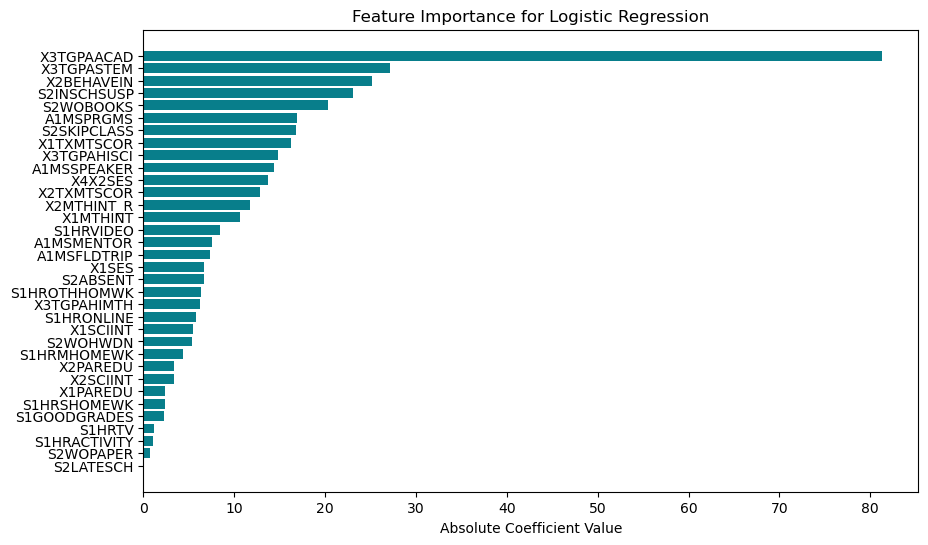

In [ ]:
importances = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': np.abs(mlr_model.coef_[0])
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance']*100, color='#087E8B')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

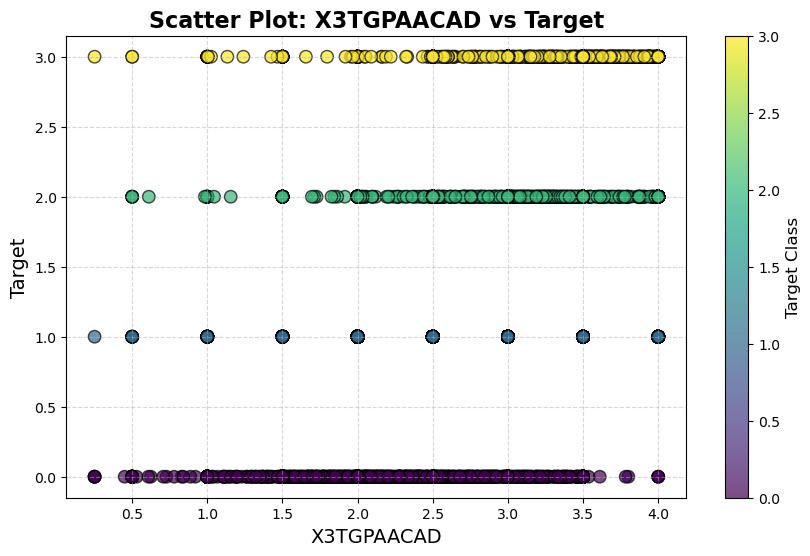

In [ ]:
feature = 'X3TGPAACAD'

plt.figure(figsize=(10, 6))

plt.scatter(
    X_train_final[feature], 
    y_train_final, 
    c=y_train_final,               
    cmap='viridis',                
    alpha=0.7,                     
    edgecolor='k',                
    s=80                            
)


plt.xlabel(feature, fontsize=14)
plt.ylabel("Target", fontsize=14)
plt.title(f"{feature} vs Target", fontsize=16, weight='bold')

plt.grid(True, linestyle='--', alpha=0.5)

cbar = plt.colorbar()
cbar.set_label('Target Class', fontsize=12)

plt.show()

### Feature Selection: Backward Elimination
We employ a wrapper method using Ordinary Least Squares (OLS) logic to iteratively remove features that do not statistically contribute to the target variable.


* **Threshold:** Features with a $p$-value $> 0.05$ are removed step-by-step.
* **Result:** This reduces model complexity and noise, retaining only statistically significant predictors.

In [15]:
import statsmodels.api as sm

def backward_elimination(X, y, sl=0.05, dropped=None):
    if dropped is None:
        dropped = []

    # Fit OLS with an intercept
    X_with_const = sm.add_constant(X)
    X_with_const = X_with_const.astype("float64")
    model = sm.MNLogit(y, X_with_const).fit(disp=False)

    # Extract p-values of x values
    pvalues = model.pvalues.iloc[1:]

    # Find the maximum p-value and corresponding feature
    pvalues = model.pvalues.iloc[1:]  # exclude intercept
    max_pvals = pvalues.max(axis=1)   # max p-value per feature

    # Find the feature with the highest p-value
    max_pval = max_pvals.max()
    if max_pval > sl:
        feature_to_drop = max_pvals.idxmax()
        dropped.append(feature_to_drop)

        # Recurse without that feature
        return backward_elimination(
            X.drop(columns=[feature_to_drop]),
            y,
            sl,
            dropped
        )
    else:
        # Stop recursion; all p-values are below threshold
        retained = list(X.columns)
        return retained, dropped, model

In [16]:
retained_1, dropped_1, final_ols_1 = backward_elimination(X_train_final, y_train_final, sl=0.10)

print("Retained features:")
print(retained_1)

print("\nDropped features:")
print(dropped_1)

Retained features:
['X1TXMTSCOR', 'X4X2SES', 'X2TXMTSCOR', 'X2MTHINT_R', 'X2BEHAVEIN', 'X3TGPAHISCI', 'X3TGPASTEM', 'X3TGPAACAD', 'S2WOBOOKS', 'S2SKIPCLASS', 'A1MSSPEAKER', 'A1MSPRGMS']

Dropped features:
['S1GOODGRADES', 'S2LATESCH', 'S1HRACTIVITY', 'X1SES', 'S2WOPAPER', 'S1HRSHOMEWK', 'S2WOHWDN', 'A1MSFLDTRIP', 'S1HRTV', 'S1HRMHOMEWK', 'X1PAREDU', 'X2PAREDU', 'S1HRVIDEO', 'S1HRONLINE', 'A1MSMENTOR', 'X3TGPAHIMTH', 'X2SCIINT', 'X1MTHINT', 'S2INSCHSUSP', 'S2ABSENT', 'X1SCIINT', 'S1HROTHHOMWK']


In [17]:
retained_5, dropped_5, final_ols_5 = backward_elimination(X_train_final, y_train_final, sl=0.05)

print("Retained features:")
print(retained_5)

print("\nDropped features:")
print(dropped_5)

Retained features:
['X4X2SES', 'X2TXMTSCOR', 'X2MTHINT_R', 'X2BEHAVEIN', 'X3TGPASTEM', 'X3TGPAACAD', 'S2WOBOOKS', 'S2SKIPCLASS']

Dropped features:
['S1GOODGRADES', 'S2LATESCH', 'S1HRACTIVITY', 'X1SES', 'S2WOPAPER', 'S1HRSHOMEWK', 'S2WOHWDN', 'A1MSFLDTRIP', 'S1HRTV', 'S1HRMHOMEWK', 'X1PAREDU', 'X2PAREDU', 'S1HRVIDEO', 'S1HRONLINE', 'A1MSMENTOR', 'X3TGPAHIMTH', 'X2SCIINT', 'X1MTHINT', 'S2INSCHSUSP', 'S2ABSENT', 'X1SCIINT', 'S1HROTHHOMWK', 'X3TGPAHISCI', 'A1MSPRGMS', 'X1TXMTSCOR', 'A1MSSPEAKER']


### Multi-class Logistic Regression Model with 0.10 p-value Retained Features

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

X_train_reduced1 = X_train_final[retained_1]
X_test_reduced1 = X_test_final[retained_1]

mlr_model2 = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model2.fit(X_train_reduced1, y_train_final)

mlr_y_hat2 = mlr_model2.predict(X_test_reduced1)

mlr_precision_2 = precision_score(y_test, mlr_y_hat2, average="macro", zero_division=0)
print("Precision:", mlr_precision_2)
mlr_recall_2 = recall_score(y_test, mlr_y_hat2, average="macro", zero_division=0)
print("Recall:", mlr_recall_2)
mlr_f1_2 = f1_score(y_test, mlr_y_hat2, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_2)
mlr_accuracy_2 = accuracy_score(y_test, mlr_y_hat2)
print("Accuracy:", mlr_accuracy_2)
print(classification_report(y_test, mlr_y_hat2, zero_division=0))

Precision: 0.4112919228872843
Recall: 0.4494513627951667
F1 Score: 0.4126955742992935
Accuracy: 0.41912932952017795
              precision    recall  f1-score   support

           0       0.43      0.63      0.51       604
           1       0.43      0.25      0.32      1027
           2       0.33      0.25      0.28       791
           3       0.45      0.67      0.54       725

    accuracy                           0.42      3147
   macro avg       0.41      0.45      0.41      3147
weighted avg       0.41      0.42      0.40      3147



### Multi-class Logistic Regression Model with 0.05 p-value Retained Features

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

X_train_reduced5 = X_train_final[retained_5]
X_test_reduced5 = X_test_final[retained_5]

mlr_model3 = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model3.fit(X_train_reduced5, y_train_final)

mlr_y_hat3 = mlr_model3.predict(X_test_reduced5)

mlr_precision_3 = precision_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("Precision:", mlr_precision_3)
mlr_recall_3 = recall_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("Recall:", mlr_recall_3)
mlr_f1_3 = f1_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_3)
mlr_accuracy_3 = accuracy_score(y_test, mlr_y_hat3)
print("Accuracy:", mlr_accuracy_3)
print(classification_report(y_test, mlr_y_hat3, zero_division=0))

Precision: 0.4116181374621951
Recall: 0.45097009410157324
F1 Score: 0.4125123370443694
Accuracy: 0.4204003813155386
              precision    recall  f1-score   support

           0       0.43      0.62      0.51       604
           1       0.43      0.25      0.31      1027
           2       0.34      0.24      0.28       791
           3       0.45      0.69      0.55       725

    accuracy                           0.42      3147
   macro avg       0.41      0.45      0.41      3147
weighted avg       0.41      0.42      0.40      3147



In [20]:
metrics1 = {
    "Baseline Model": {
        "Precision": mlr_precision_1,
        "Recall": mlr_recall_1,
        "F1 Score": mlr_f1_1,
        "Accuracy": mlr_accuracy_1
    },
    "Reduced Model 0.10": {
        "Precision": mlr_precision_2,
        "Recall": mlr_recall_2,
        "F1 Score": mlr_f1_2,
        "Accuracy": mlr_accuracy_2
    },
    "Reduced Model 0.05": {
        "Precision": mlr_precision_3,
        "Recall": mlr_recall_3,
        "F1 Score": mlr_f1_3,
        "Accuracy": mlr_accuracy_3
    }
}

metric1_df = pd.DataFrame(metrics1)

display(metric1_df)

,Baseline Model,Reduced Model 0.10,Reduced Model 0.05
Precision,0.418786,0.411292,0.411618
Recall,0.450514,0.449451,0.450970
F1 Score,0.421244,0.412696,0.412512
Accuracy,0.423896,0.419129,0.420400


### Dimensionality Reduction Comparison
We compare three techniques to reduce the feature space while retaining predictive power:
1.  **PCA (Principal Component Analysis):** Unsupervised linear reduction.
2.  **LDA (Linear Discriminant Analysis):** Supervised reduction that maximizes class separability.
3.  **Kernel PCA:** Non-linear reduction using Radial Basis Function (RBF).


*The plot below visualizes the Cumulative Explained Variance to help us select the optimal number of components.*

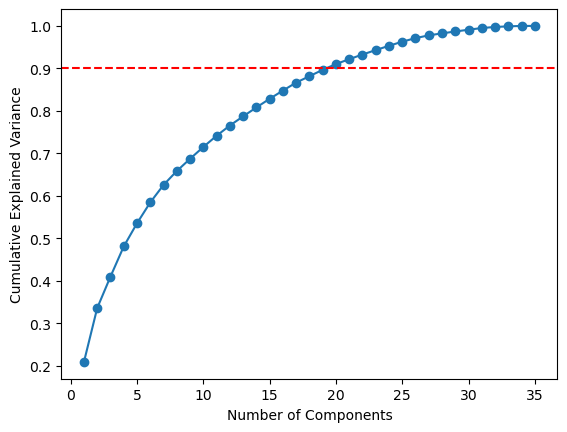

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X_train_final)

# Plot cumulative explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--')  # target threshold
plt.show()

In [22]:
from sklearn.decomposition import PCA

pca18 = PCA(n_components=18)
X_train_pca18 = pca18.fit_transform(X_train_final)
X_test_pca18 = pca18.transform(X_test_final)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_pca = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_pca.fit(X_train_pca18, y_train_final)

mlr_y_hat4 = mlr_model_pca.predict(X_test_pca18)

mlr_precision_4 = precision_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("Precision:", mlr_precision_4)
mlr_recall_4 = recall_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("Recall:", mlr_recall_4)
mlr_f1_4 = f1_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_4)
mlr_accuracy_4 = accuracy_score(y_test, mlr_y_hat4)
print("Accuracy:", mlr_accuracy_4)
print(classification_report(y_test, mlr_y_hat4, zero_division=0))

Precision: 0.41519993074396694
Recall: 0.45172955114367175
F1 Score: 0.41754405211715945
Accuracy: 0.42198919605973945
              precision    recall  f1-score   support

           0       0.43      0.64      0.51       604
           1       0.44      0.26      0.33      1027
           2       0.33      0.26      0.29       791
           3       0.47      0.64      0.54       725

    accuracy                           0.42      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.42      0.40      3147



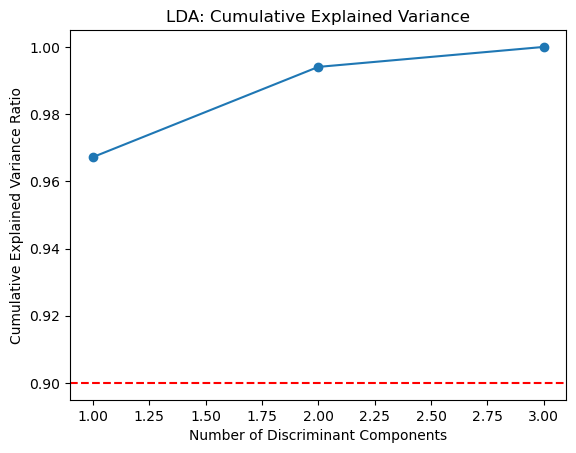

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_train_lda = lda.fit_transform(X_train_final, y_train_final)
X_test_lda = lda.transform(X_test_final)

plt.plot(range(1, len(lda.explained_variance_ratio_)+1),
         np.cumsum(lda.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Discriminant Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% threshold
plt.title('LDA: Cumulative Explained Variance')
plt.show()

lda = LinearDiscriminantAnalysis(n_components=3)

X_train_lda = lda.fit_transform(X_train_final, y_train_final)
X_test_lda = lda.transform(X_test_final)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_lda = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_lda.fit(X_train_lda, y_train_final)

mlr_y_hat5 = mlr_model_lda.predict(X_test_lda)

mlr_precision_5 = precision_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("Precision:", mlr_precision_5)
mlr_recall_5 = recall_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("Recall:", mlr_recall_5)
mlr_f1_5 = f1_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_5)
mlr_accuracy_5 = accuracy_score(y_test, mlr_y_hat5)
print("Accuracy:", mlr_accuracy_5)
print(classification_report(y_test, mlr_y_hat5, zero_division=0))

Precision: 0.4202424779416388
Recall: 0.4523740433731166
F1 Score: 0.42348814676414726
Accuracy: 0.42548458849698123
              precision    recall  f1-score   support

           0       0.43      0.61      0.51       604
           1       0.45      0.27      0.34      1027
           2       0.33      0.28      0.30       791
           3       0.47      0.64      0.54       725

    accuracy                           0.43      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.43      0.41      3147



In [26]:
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),
    ('clf', LogisticRegression(max_iter=1000, random_state=seed))
])

param_grid = {
    'kpca__n_components': list(range(5, 31))
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train_final, y_train_final)

kpca_comp = grid.best_params_['kpca__n_components']

print("Best number of components:", kpca_comp)

Best number of components: 29


In [27]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=kpca_comp, kernel='rbf')

X_train_kpca = kpca.fit_transform(X_train_final)
X_test_kpca = kpca.transform(X_test_final)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_kpca = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_kpca.fit(X_train_kpca, y_train_final)

mlr_y_hat6 = mlr_model_kpca.predict(X_test_kpca)

mlr_precision_6 = precision_score(y_test, mlr_y_hat6, average="macro", zero_division=0)
print("Precision:", mlr_precision_6)
mlr_recall_6 = recall_score(y_test, mlr_y_hat6, average="macro", zero_division=0)
print("Recall:", mlr_recall_6)
mlr_f1_6 = f1_score(y_test, mlr_y_hat6, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_6)
mlr_accuracy_6 = accuracy_score(y_test, mlr_y_hat6)
print("Accuracy:", mlr_accuracy_6)
print(classification_report(y_test, mlr_y_hat6, zero_division=0))

Precision: 0.4131709646807718
Recall: 0.44445576860440433
F1 Score: 0.4187615249606233
Accuracy: 0.4204003813155386
              precision    recall  f1-score   support

           0       0.42      0.62      0.50       604
           1       0.42      0.30      0.35      1027
           2       0.33      0.26      0.29       791
           3       0.48      0.60      0.54       725

    accuracy                           0.42      3147
   macro avg       0.41      0.44      0.42      3147
weighted avg       0.41      0.42      0.41      3147



In [29]:
metrics2 = {
    "PCA Model": {
        "Precision": mlr_precision_4,
        "Recall": mlr_recall_4,
        "F1 Score": mlr_f1_4,
        "Accuracy": mlr_accuracy_4
    },
    "LDA Model": {
        "Precision": mlr_precision_5,
        "Recall": mlr_recall_5,
        "F1 Score": mlr_f1_5,
        "Accuracy": mlr_accuracy_5
    },
    "KPCA Model": {
        "Precision": mlr_precision_6,
        "Recall": mlr_recall_6,
        "F1 Score": mlr_f1_6,
        "Accuracy": mlr_accuracy_6
    }
}

metric2_df = pd.DataFrame(metrics2)

display(metric2_df)

,PCA Model,LDA Model,KPCA Model
Precision,0.415200,0.420242,0.413171
Recall,0.451730,0.452374,0.444456
F1 Score,0.417544,0.423488,0.418762
Accuracy,0.421989,0.425485,0.420400


### Comparative Classification
Having identified **LDA** as the strongest dimensionality reduction technique in previous steps, we now train various classifiers on the `X_train_lda` dataset to find the best performing algorithm:
* **Stochastic Gradient Descent (SGD)**
* **XGBoost (Gradient Boosting)**
* **Random Forest (Bagging)**
* **Support Vector Classifier (SVC)**
* **AdaBoost**
* **Gaussian Naive Bayes**

### Stochastic Gradient Descent

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_model_lda = SGDClassifier(loss='log_loss', max_iter=1000, random_state=seed).fit(X_train_lda, y_train_final)

sgd_y_hat = sgd_model_lda.predict(X_test_lda)

sgd_precision = precision_score(y_test, sgd_y_hat, average="macro", zero_division=0)
print("Precision:", sgd_precision)
sgd_recall = recall_score(y_test, sgd_y_hat, average="macro", zero_division=0)
print("Recall:", sgd_recall)
sgd_f1 = f1_score(y_test, sgd_y_hat, average="macro", zero_division=0)
print("F1 Score:", sgd_f1)
sgd_accuracy = accuracy_score(y_test, sgd_y_hat)
print("Accuracy:", sgd_accuracy)
print(classification_report(y_test, sgd_y_hat, zero_division=0))

Precision: 0.39549966755339344
Recall: 0.44028922732433684
F1 Score: 0.36480083481594017
Accuracy: 0.40355894502700984
              precision    recall  f1-score   support

           0       0.40      0.71      0.51       604
           1       0.42      0.25      0.31      1027
           2       0.36      0.07      0.11       791
           3       0.40      0.74      0.52       725

    accuracy                           0.40      3147
   macro avg       0.40      0.44      0.36      3147
weighted avg       0.40      0.40      0.35      3147



## XGBoost

In [31]:
from xgboost import XGBClassifier

xgb_model_lda  = XGBClassifier().fit(X_train_lda, y_train_final)

xgb_y_hat = xgb_model_lda.predict(X_test_lda)

xgb_precision = precision_score(y_test, xgb_y_hat, average="macro", zero_division=0)
print("Precision:", xgb_precision)
xgb_recall = recall_score(y_test, xgb_y_hat, average="macro", zero_division=0)
print("Recall:", xgb_recall)
xgb_f1 = f1_score(y_test, xgb_y_hat, average="macro", zero_division=0)
print("F1 Score:", xgb_f1)
xgb_accuracy = accuracy_score(y_test, xgb_y_hat)
print("Accuracy:", xgb_accuracy)
print(classification_report(y_test, xgb_y_hat, zero_division=0))

Precision: 0.41051132756830055
Recall: 0.4266000639296594
F1 Score: 0.4127354627895986
Accuracy: 0.407689863361932
              precision    recall  f1-score   support

           0       0.39      0.57      0.47       604
           1       0.41      0.31      0.35      1027
           2       0.33      0.33      0.33       791
           3       0.51      0.50      0.50       725

    accuracy                           0.41      3147
   macro avg       0.41      0.43      0.41      3147
weighted avg       0.41      0.41      0.40      3147



## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model_lda = RandomForestClassifier(random_state=seed)

param_grid = {
     'criterion': ['gini', 'entropy'],
     'n_estimators': np.arange(3, 50).tolist()

}

grid_search = GridSearchCV(estimator=rf_model_lda,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro')

grid_search.fit(X_train_lda, y_train_final)

best_critertion = grid_search.best_params_['criterion']
best_max_depth = grid_search.best_params_['n_estimators']

print("Best Critertion: ", best_critertion)
print("Best Max Depth: ", best_max_depth)

Best Critertion:  entropy
Best Max Depth:  49


In [33]:
rf_model_lda = RandomForestClassifier(criterion=best_critertion, max_depth=best_max_depth, random_state=seed).fit(X_train_lda, y_train_final)

rf_y_hat = rf_model_lda.predict(X_test_lda)

rf_precision = precision_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("Precision:", rf_precision)
rf_recall = recall_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("Recall:", rf_recall)
rf_f1 = f1_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("F1 Score:", rf_f1)
rf_accuracy = accuracy_score(y_test, rf_y_hat)
print("Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_y_hat, zero_division=0))

Precision: 0.406172676826387
Recall: 0.42427665323798625
F1 Score: 0.41038787308887315
Accuracy: 0.40800762631077214
              precision    recall  f1-score   support

           0       0.39      0.55      0.46       604
           1       0.42      0.34      0.37      1027
           2       0.32      0.29      0.30       791
           3       0.49      0.52      0.51       725

    accuracy                           0.41      3147
   macro avg       0.41      0.42      0.41      3147
weighted avg       0.41      0.41      0.40      3147



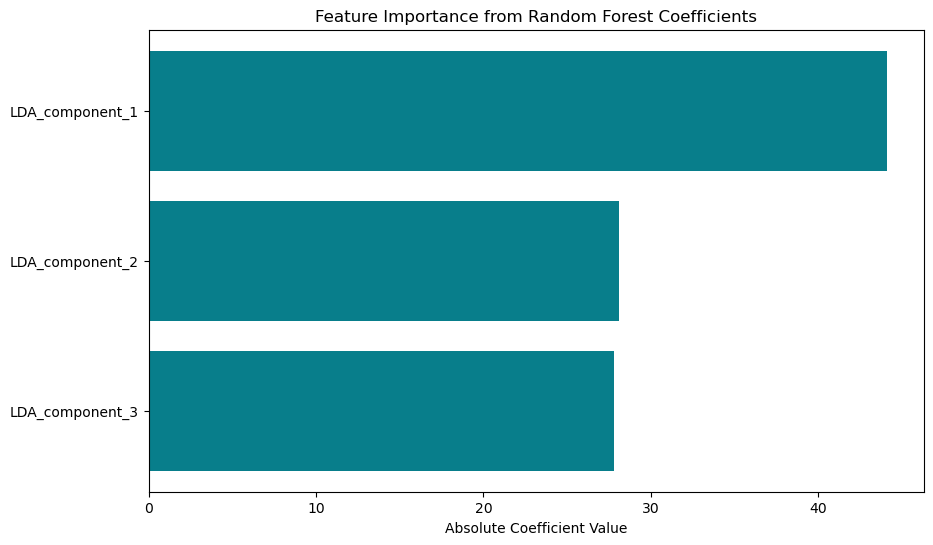

In [85]:
lda_feature_names = [f"LDA_component_{i+1}" for i in range(len(rf_model_lda.feature_importances_))]

importances = pd.DataFrame({
    'Feature': lda_feature_names,
    'Importance': np.abs(rf_model_lda.feature_importances_)  # Use absolute value for importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance']*100, color='#087E8B')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from Random Forest Coefficients')
plt.gca().invert_yaxis()
plt.show()

In [78]:
X_train_lda

array([[-4.71196253e-01, -4.09869912e-02,  1.51748354e+00],
       [ 1.32132860e+00, -2.97510805e-04,  1.87521510e+00],
       [ 3.48301682e-01,  1.10397155e+00,  6.40411482e-01],
       ...,
       [ 1.89772618e+00,  1.01487567e+00,  5.62860946e-01],
       [ 3.28140920e-01, -5.50801146e-01, -1.35487716e+00],
       [ 1.58844787e+00,  7.56764319e-02, -4.86923101e-01]])

## Support Vector Classifier

In [34]:
from sklearn.svm import SVC

svm_model_lda = SVC(random_state=seed)

param_grid = {
     'kernel': ['rbf', 'poly'],
     'C': [0.1, 1, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale']
}

grid_search = GridSearchCV(estimator=svm_model_lda,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro')

grid_search.fit(X_train_lda, y_train_final)

best_kernel = grid_search.best_params_['kernel']
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

print("Best Kernel: ", best_kernel)
print("Best C: ", best_C)
print("Best Gamma: ", best_gamma)

Best Kernel:  rbf
Best C:  0.1
Best Gamma:  0.1


In [35]:
svm_model_lda = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma, random_state=seed).fit(X_train_lda, y_train_final)

svm_y_hat = svm_model_lda.predict(X_test_lda)

svm_precision = precision_score(y_test, svm_y_hat, average="macro", zero_division=0)
print("Precision:", svm_precision)
svm_recall = recall_score(y_test, svm_y_hat, average="macro", zero_division=0)
print("Recall:", svm_recall)
svm_f1 = f1_score(y_test, svm_y_hat, average="macro", zero_division=0)
print("F1 Score:", svm_f1)
svm_accuracy = accuracy_score(y_test, svm_y_hat)
print("Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_y_hat, zero_division=0))

Precision: 0.43201470490568217
Recall: 0.4518236435997404
F1 Score: 0.43520532053191313
Accuracy: 0.4305687956784239
              precision    recall  f1-score   support

           0       0.42      0.62      0.50       604
           1       0.43      0.32      0.37      1027
           2       0.35      0.34      0.34       791
           3       0.53      0.53      0.53       725

    accuracy                           0.43      3147
   macro avg       0.43      0.45      0.44      3147
weighted avg       0.43      0.43      0.42      3147



## ADA Boost Classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier

ada_model_lda = AdaBoostClassifier(random_state=seed)

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(estimator=ada_model_lda,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro')

grid_search.fit(X_train_lda, y_train_final)

best_n_estimator = grid_search.best_params_['n_estimators']
best_learn = grid_search.best_params_['learning_rate']

print("Best No of Estimators: ", best_n_estimator)
print("Best Learning Rate: ", best_learn)

Best No of Estimators:  50
Best Learning Rate:  1.0


In [37]:
ada_model_lda = AdaBoostClassifier(mlr_model_lda, n_estimators=best_n_estimator, learning_rate=best_learn, random_state=seed)
ada_model_lda.fit(X_train_lda, y_train_final)

ada_y_hat = ada_model_lda.predict(X_test_lda)

ada_precision = precision_score(y_test, ada_y_hat, average="macro", zero_division=0)
print("Precision:", ada_precision)
ada_recall = recall_score(y_test, ada_y_hat, average="macro", zero_division=0)
print("Recall:", ada_recall)
ada_f1 = f1_score(y_test, ada_y_hat, average="macro", zero_division=0)
print("F1 Score:", ada_f1)
ada_accuracy = accuracy_score(y_test, ada_y_hat)
print("Accuracy:", ada_accuracy)
print(classification_report(y_test, ada_y_hat, zero_division=0))

Precision: 0.4570907691616485
Recall: 0.4647060432835557
F1 Score: 0.4457877980854389
Accuracy: 0.4388306323482682
              precision    recall  f1-score   support

           0       0.45      0.63      0.53       604
           1       0.46      0.26      0.33      1027
           2       0.35      0.49      0.41       791
           3       0.57      0.48      0.52       725

    accuracy                           0.44      3147
   macro avg       0.46      0.46      0.45      3147
weighted avg       0.46      0.44      0.43      3147



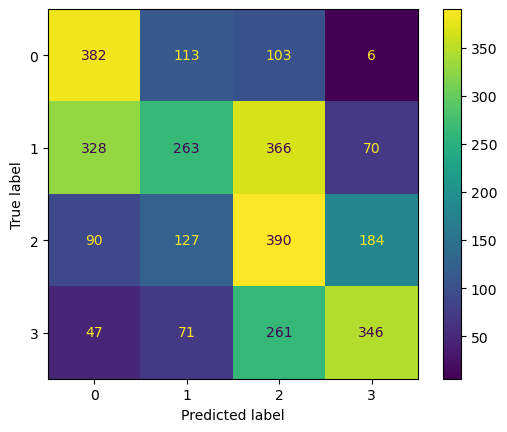

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, ada_y_hat)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_model_lda.classes_).plot()
plt.show()

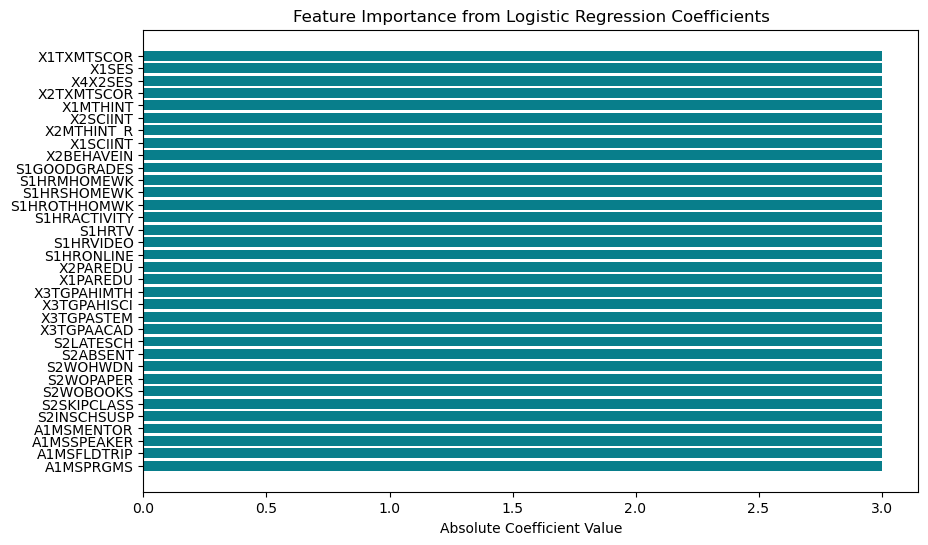

In [75]:
importances = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': np.abs(ada_model_lda.n_features_in_)  # Use absolute value for importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'], color='#087E8B')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

array([[-0.97703841,  0.07458991, -0.01124158],
       [-0.33428932, -0.09506341,  0.07580498],
       [ 0.29922906, -0.07346758, -0.09573267],
       [ 1.01209868,  0.09394108,  0.03116927]])

## Gaussian Naive Bayes Classifier

In [38]:
from sklearn.naive_bayes import GaussianNB

gnb_model_lda = GaussianNB()
gnb_model_lda.fit(X_train_lda, y_train_final)

gnb_y_hat = gnb_model_lda.predict(X_test_lda)

gnb_precision = precision_score(y_test, gnb_y_hat, average="macro", zero_division=0)
print("Precision:", gnb_precision)
gnb_recall = recall_score(y_test, gnb_y_hat, average="macro", zero_division=0)
print("Recall:", gnb_recall)
gnb_f1 = f1_score(y_test, gnb_y_hat, average="macro", zero_division=0)
print("F1 Score:", gnb_f1)
gnb_accuracy = accuracy_score(y_test, gnb_y_hat)
print("Accuracy:", gnb_accuracy)
print(classification_report(y_test, gnb_y_hat, zero_division=0))

Precision: 0.4159487713894555
Recall: 0.44611554392545105
F1 Score: 0.41804844007758585
Accuracy: 0.4184938036224976
              precision    recall  f1-score   support

           0       0.43      0.60      0.50       604
           1       0.44      0.25      0.32      1027
           2       0.33      0.31      0.32       791
           3       0.46      0.63      0.53       725

    accuracy                           0.42      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.42      0.40      3147



### Ensemble Strategy: Voting Classifier
To improve model robustness and reduce variance, we combine our top performing independent models (`XGBoost`, `Random Forest`, `SVC`, and `Naive Bayes`) into a **Voting Classifier**.


* **Method:** Hard Voting (Majority Rule).
* **Goal:** To smooth out individual model errors by aggregating predictions.

In [39]:
from sklearn.ensemble import VotingClassifier

vc_model = VotingClassifier(estimators=[('xgb', xgb_model_lda), ('rf', rf_model_lda), 
                                        ('svc', svm_model_lda), ('gnb', gnb_model_lda)], voting='hard')

vc_model = vc_model.fit(X_train_lda, y_train_final)

vc_y_hat = vc_model.predict(X_test_lda)

vc_precision = precision_score(y_test, vc_y_hat, average="macro", zero_division=0)
print("Precision:", vc_precision)
vc_recall = recall_score(y_test, vc_y_hat, average="macro", zero_division=0)
print("Recall:", vc_recall)
vc_f1 = f1_score(y_test, vc_y_hat, average="macro", zero_division=0)
print("F1 Score:", vc_f1)
vc_accuracy = accuracy_score(y_test, vc_y_hat)
print("Accuracy:", vc_accuracy)
print(classification_report(y_test, vc_y_hat, zero_division=0))

Precision: 0.42746507498415065
Recall: 0.44821773262304787
F1 Score: 0.42776950121831353
Accuracy: 0.4238957737527804
              precision    recall  f1-score   support

           0       0.41      0.65      0.50       604
           1       0.43      0.30      0.35      1027
           2       0.35      0.34      0.35       791
           3       0.52      0.50      0.51       725

    accuracy                           0.42      3147
   macro avg       0.43      0.45      0.43      3147
weighted avg       0.43      0.42      0.42      3147



### Final Performance Evaluation
The bar chart below aggregates the Precision, Recall, F1-Score, and Accuracy across all trained models.
* **Observation:** We look for the model with the highest **F1-Score**, as it balances Precision and Recall, providing a robust metric for our multi-class GPA prediction problem.

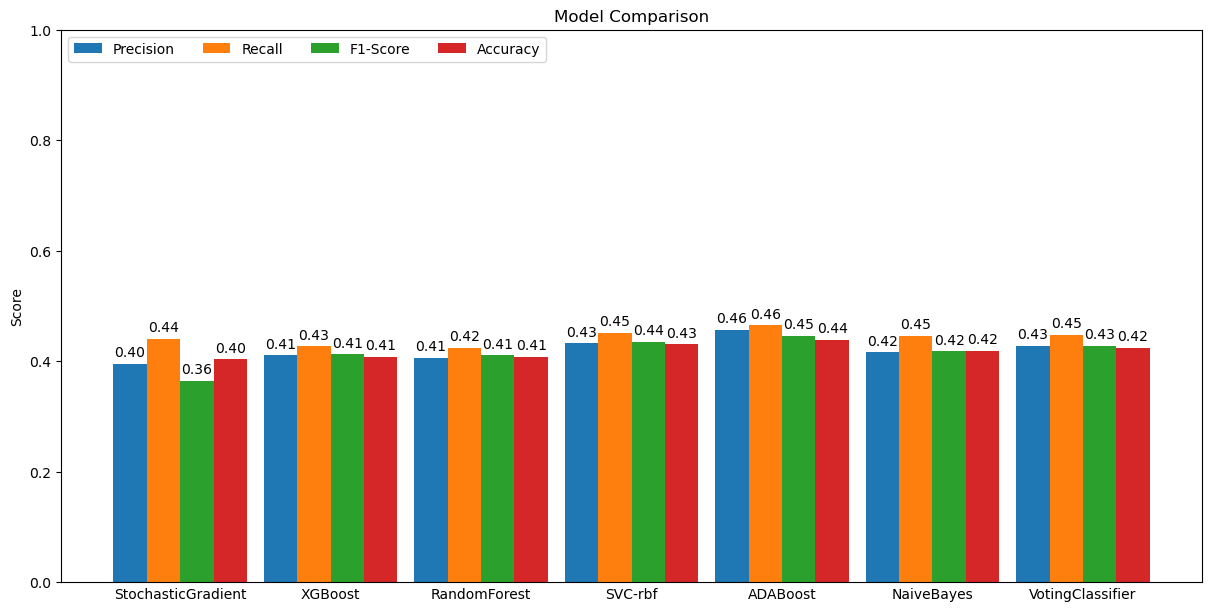

In [40]:
models = ("StochasticGradient","XGBoost","RandomForest", "SVC-rbf", "ADABoost", "NaiveBayes","VotingClassifier")
model_metrics = {
    'Precision': (sgd_precision, xgb_precision, rf_precision, svm_precision, ada_precision, gnb_precision, vc_precision),
    'Recall': (sgd_recall, xgb_recall, rf_recall, svm_recall, ada_recall, gnb_recall, vc_recall),
    'F1-Score': (sgd_f1, xgb_f1, rf_f1, svm_f1, ada_f1, gnb_f1, vc_f1),
    'Accuracy': (sgd_accuracy, xgb_accuracy, rf_accuracy, svm_accuracy, ada_accuracy, gnb_accuracy, vc_accuracy)
}

width = 0.50  # the width of the bars
x = np.arange(len(models)) * (width * len(model_metrics) + 0.25)  # the label locations
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

for metric, score in model_metrics.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, score, width, label=metric)
    ax.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1

group_width = width * multiplier
ax.set_xticks(x + group_width / 2 - width / 2)
ax.set_xticklabels(models)
ax.tick_params(axis='x', length=0)
#plt.xticks(rotation=45, ha='right')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

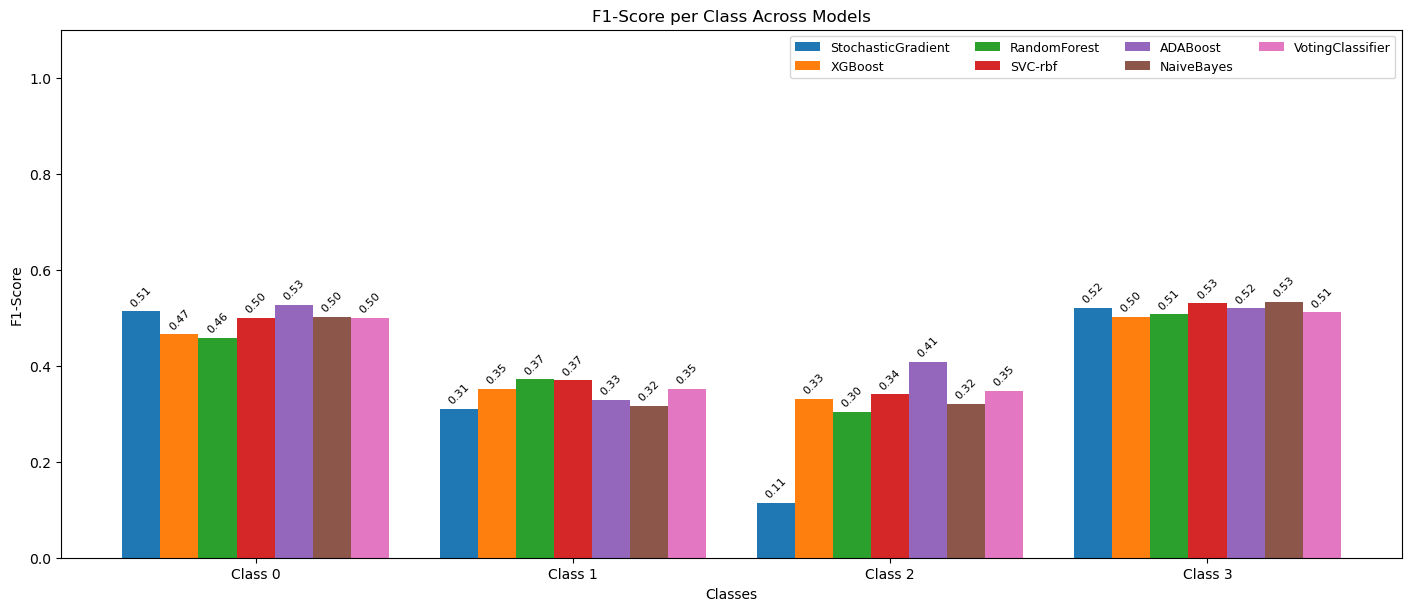

In [41]:
plot_scores = [
    # to calcualte f1 for each class.
    f1_score(y_test, sgd_y_hat, average=None), 
    f1_score(y_test, xgb_y_hat, average=None),
    f1_score(y_test, rf_y_hat,  average=None),
    f1_score(y_test, svm_y_hat, average=None),
    f1_score(y_test, ada_y_hat, average=None),
    f1_score(y_test, gnb_y_hat, average=None),
    f1_score(y_test, vc_y_hat,  average=None)
]

models = ["StochasticGradient","XGBoost","RandomForest", "SVC-rbf", 
          "ADABoost", "NaiveBayes","VotingClassifier"]

n_models = len(models)
n_classes = 4
width = 0.12
x = np.arange(n_classes)

fig, ax = plt.subplots(figsize=(14, 6), layout='constrained')

for i, model_name in enumerate(models):
    offset = (i - n_models/2) * width + width/2
    scores = plot_scores[i] 
    
    rects = ax.bar(x + offset, scores, width, label=model_name)
    ax.bar_label(rects, padding=2, fmt="%.2f", rotation=45, fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels([f"Class {i}" for i in range(n_classes)])
ax.set_ylim(0, 1.1)
ax.set_xlabel("Classes")
ax.set_ylabel("F1-Score")
ax.set_title("F1-Score per Class Across Models")
ax.legend(ncols=4, fontsize=9)

plt.show()

-------------------